In [1]:
import pyvisa

rm = pyvisa.ResourceManager()
print(rm.list_resources())

deviceIDNs = {}

for device in rm.list_resources():
    _device = rm.open_resource(device)
    _IDN = _device.query('*IDN?')
    deviceIDNs[device] = _IDN

for key,value in deviceIDNs.items():
    if 'SO-X' in value:
        scopeResource = key
        break

scope = rm.open_resource(scopeResource)
scope.timeout = 10000
print(scope.query('*IDN?'))

('USB0::0x0957::0x17B6::MY55110206::0::INSTR',)
AGILENT TECHNOLOGIES,MSO-X 4024A,MY55110206,07.35.2020120823



In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def waveformCapture(sourceList, timestampOffset = 0, waveformPoints = 'NORMal' ):
    #Setup data export
    scope.write(":WAVeform:FORMat WORD")                    #16 bit word format
    scope.write(":WAVeform:BYTeorder LSBFirst")             #Explicitly set this to avoid confusion
    scope.write(":WAVeform:UNSigned 0")                     #Explicitly set this to avoid confusion
    scope.write(f':WAVeform:POINts:MODE {waveformPoints}')  #Normal / Max

    for source in sourceList:
        scope.write(f":WAVeform:SOURce {source}")       #Set waveform source
        
        #Get preamble data and parse it
        preamble = scope.query(":WAVeform:PREamble?").split(',')

        acqMode        = int(preamble[1])                       #Scope acquisition mode
        datapoints     = int(preamble[2])                       #Get number of acqusition points
        xIncrement     = float(preamble[4])                     #Time difference between data points
        xOrigin        = float(preamble[5])                     #Always the first data point in memory
        xReference     = int(preamble[6])                       #Specifies the data point associated with x-origin
        yIncrement     = float(preamble[7])                     #Voltage difference between data points
        yOrigin        = float(preamble[8])                     #Voltage at center screen
        yReference     = int(preamble[9])                       #Specifies the data point associated with y-origin

        try:
            waveformTimeDataFrame
        except NameError:
            #Create an arry of time values using the preamble data, convert it to a dataframe.  Only needs to be done once
            waveformTime = ((np.linspace(0, datapoints-1, datapoints) - xReference) * xIncrement ) + xOrigin + timestampOffset
            waveformTimeDataFrame = pd.DataFrame(waveformTime, columns = ['Timestamp'])
            waveformOutput = waveformTimeDataFrame

        #Get the waveform data, convert it to a dataframe, scale it
        waveformData = scope.query_binary_values(f':WAVeform:SOURce {source}' + ';DATA?', "h", False)  #Returns a List
        waveformDataFrame = pd.DataFrame(waveformData, columns = ['Raw Data'])
        waveformDataFrame[f'{source} Data'] = ((waveformDataFrame['Raw Data'] - yReference) * yIncrement) + yOrigin
        waveformDataFrame = waveformDataFrame.drop(columns = ['Raw Data'])

        #Join the time dataframe to the voltage dataframe
        waveformOutput = waveformOutput.join(waveformDataFrame)

    return(waveformOutput)

def waveformPlotter(acqDataframe, figsizeX = 10):
    #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html
    plt.close("all")

    waveformData = list(acqDataframe.columns)[1:]

    waveformPlot = acqDataframe.plot(x = 'Timestamp', y = waveformData, title = 'Waveform Data', xlabel = 'Time (Seconds)', ylabel = 'Voltage (Volts)', figsize = (figsizeX,8) , grid = True, legend = True)

    return(waveformPlot)

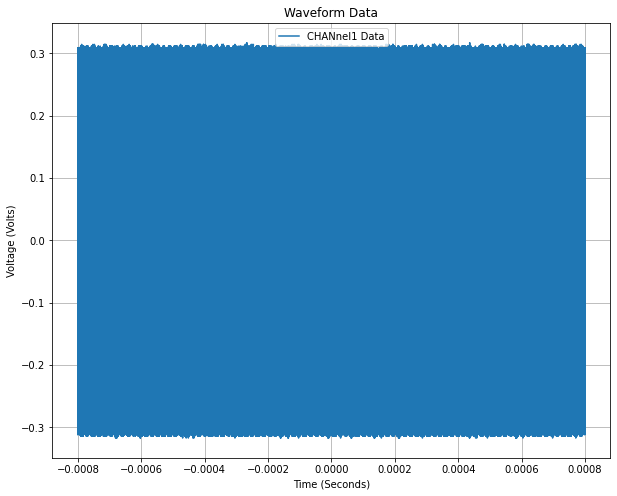

In [7]:
#Single Channel Capture
waveformDataframe = waveformCapture(['CHANnel1'], waveformPoints = 'MAX')
samplePlot = waveformPlotter(waveformDataframe)   
samplePlot.get_figure().savefig("output.png")

In [8]:
waveformDataframe.to_csv('waveform_25gsps_4m.csv.gz', index = False)

In [ ]:
#Multi Channel Capture
waveformDataframe = waveformCapture(['CHANnel1', 'CHANnel2'])
samplePlot = waveformPlotter(waveformDataframe)   
samplePlot.get_figure().savefig("output.png")

In [ ]:
#Math Channel Capture
waveformDataframe = waveformCapture(['MATH1'])
samplePlot = waveformPlotter(waveformDataframe)   
samplePlot.get_figure().savefig("output.png")

In [ ]:
#Segmented Capture | With Time Offset
segmentCount = int(scope.query(":WAVeform:SEGMented:COUNt?"))

segmentTimetags = {}
waveformDataframeList = []

for n in range(1, segmentCount + 1, 1):   
    scope.write(f":ACQuire:SEGMented:INDex {n}")
    segmentTimetags[n] = float(scope.query(":WAVeform:SEGMented:TTAG?"))  # Get time tag of segment n ; always get time tags
    
for key,value in segmentTimetags.items():
    scope.write(f":ACQuire:SEGMented:INDex {key}")
    capture = waveformCapture(1, value)
    capture['Segment Number'] = key
    waveformDataframeList.append(capture)

allSegmentOutput = pd.concat(waveformDataframeList)
waveformPlotter(allSegmentOutput, figsizeX = 26)

In [ ]:
#Segmented Capture | Without Time Offset
segmentCount = int(scope.query(":WAVeform:SEGMented:COUNt?"))

segmentTimetags = {}
timespanList = []
waveformDataframeList = []

for n in range(1, segmentCount + 1, 1):   
    scope.write(f":ACQuire:SEGMented:INDex {n}")
    segmentTimetags[n] = float(scope.query(":WAVeform:SEGMented:TTAG?"))  # Get time tag of segment n ; always get time tags
    
for key,value in segmentTimetags.items():
    scope.write(f":ACQuire:SEGMented:INDex {key}")
    if key == 1:
        capture = waveformCapture(1)
        capture['Segment Number'] = key
        waveformDataframeList.append(capture)
        timespan = capture['Timestamp'].max() - capture['Timestamp'].min()
        triggerOffset = capture['Timestamp'].min()
    else:
        capture = waveformCapture(1, timespan)
        capture['Segment Number'] = key
        waveformDataframeList.append(capture)
        timespan = timespan + capture['Timestamp'].max() - capture['Timestamp'].min()
    timespanList.append(timespan)
        

allSegmentOutput = pd.concat(waveformDataframeList)
samplePlot = waveformPlotter(allSegmentOutput, figsizeX = 26)

for timespan in timespanList:
    samplePlot.axvline(x = timespan + triggerOffset, color = 'r')

In [4]:
waveformDataframe.to_csv('Waveform Sample.csv.gz', index = False)